In [1]:
import ot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

from utils.plot import scatterplot
from utils.plot import plot_gamma_with_marginals
from utils.plot import discrete_gamma_marg

from utils.preprocessing import feature_scaling
from utils.preprocessing import feature_normalization

from dynamic_systems.controller import PID
from dynamic_systems.simulation import TwoTanks
from statsmodels.tsa.stattools import acf

from sklearn.svm import SVC

plt.style.use('science')

plt.rcParams['mathtext.fontset'] = 'custom' 
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans' 
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic' 
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold' 
plt.rcParams['font.size'] = 16 
plt.rcParams['mathtext.fontset'] = 'stix' 
plt.rcParams['font.family'] = 'STIXGeneral' 

palette = sns.color_palette('tab10', n_colors=5)
palette_cmap = ListedColormap(palette.as_hex())

In [2]:
def make_grid(x, y, n_points=100):
    x_min, x_max = x.min() - .25, x.max() + .25
    y_min, y_max = y.min() - .25, y.max() + .25
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(x_min, x_max, n_points))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.pcolormesh(xx, yy, Z, **params)
    return out

In [7]:
def rwalk(x, sigma=1e-4):
    return sigma * np.random.randn()

## Random Walk Example

In [21]:
t0 = 0
t = t0
dt = 0.1
x0 = 0
x = x0
T = [t0]
X = [x0]
for i in range(1000):
    t = t + dt
    x = x + rwalk(x, sigma=1e-2) * dt
    T.append(t)
    X.append(x)

In [50]:
plt.text

<function matplotlib.pyplot.text(x, y, s, fontdict=None, **kwargs)>

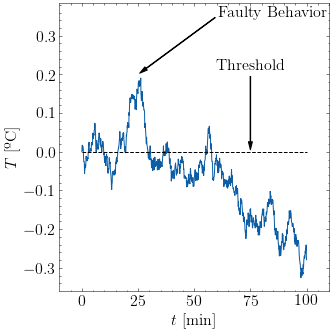

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(T, 10 * np.array(X))
ax.plot(T, [0.00] * len(T), 'k--')
ax.set_ylabel(r'$T$ [ºC]')
ax.set_xlabel(r'$t$ [min]')

style = "Simple, tail_width=0.5, head_width=4, head_length=8" 
kw = dict(arrowstyle=style, color="k")
patch1 = patches.FancyArrowPatch((75, 10 * 0.02), (75, 0.0), **kw)
ax.add_patch(patch1)
ax.text(75, 10 * 0.021, "Threshold", horizontalalignment="center")

patch2 = patches.FancyArrowPatch((60, 10 * 0.035), (25, 10 * 0.02), **kw)
ax.add_patch(patch2)
ax.text(85, 10 * 0.035, "Faulty Behavior", horizontalalignment="center")

ax.set_xlim([-10, 110])

plt.tight_layout()
plt.savefig('./Figures/Presentation/FaultyBehavior.pdf', transparent=True)

## Two Tanks Correlation

In [ ]:
data = np.load('./data/ttanks_raw_0.05.npy')
X = data[:, :-1]
y = data[:, -1]

udata = X[np.where(y == 2)[0], :750]
ydata = X[np.where(y == 2)[0], 750:]

plt.plot(t, ydata[0, :])

In [ ]:
R = np.corrcoef(ydata.T)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

im = ax.imshow(R, cmap='viridis')
_ = ax.set_yticks(np.arange(0, 750, 50).astype(int))
_ = ax.set_xticks(np.arange(0, 750, 50).astype(int))
ax.set_ylabel('$n$')
ax.set_xlabel('$m$')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.set_ylabel('$R_{nm}$', rotation=90)


In [ ]:
fig3 = plt.figure(constrained_layout=True, figsize=(7, 5))
#widths = [1, 1]
#heights = [1, 1]
# gs = fig3.add_gridspec(2, 3, width_ratios=widths, height_ratios=heights)

gs = fig3.add_gridspec(2, 2)
ax = fig3.add_subplot(gs[0, 0])
ax.scatter(ydata[:, 50], ydata[:, 60], edgecolor='k')
ax.set_ylabel('$X_{60}$')
ax.set_xlabel('$X_{50}$')
ax.set_title('$R_{ij} = $' + '{}'.format(np.round(R[50, 60], 3)))
ax = fig3.add_subplot(gs[1, 0])
ax.scatter(ydata[:, 400], ydata[:, 500], edgecolor='k')
ax.set_ylabel('$X_{400}$')
ax.set_xlabel('$X_{500}$')
ax.set_title('$R_{ij} = $' + '{}'.format(np.round(R[0, 10], 3)))
ax = fig3.add_subplot(gs[:, 1:])
im = ax.imshow(R, cmap='viridis', aspect='auto')
_ = ax.set_yticks([i * 150 for i in range(6)])
_ = ax.set_xticks([i * 150 for i in range(6)])
ax.set_ylabel('$i$')
ax.set_xlabel('$j$')
ax.set_title('$R_{ij}$')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', aspect='auto')
plt.tight_layout()

plt.savefig('./Figures/Ch3/corr_ex.pdf', transparent=True)

In [ ]:
print('Number of samples considered: {}'.format(len(np.where(y == 0)[0])))

## AWGN Signal

In [ ]:
x = 0.75 + 5e-2 * np.random.randn(1000)
Rxx = acf(x, fft=True, nlags=250)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

axes[0].plot(np.linspace(0, 100, 1000), x)
axes[0].set_ylabel('$x(t)$')
axes[0].set_xlabel('$t$')
axes[1].plot(np.linspace(0, 25, 251), Rxx)
axes[1].set_ylabel(r'$R_{xx}(\tau)$')
axes[1].set_xlabel(r'$\tau$')

plt.tight_layout()
plt.savefig('./Figures/Ch3/AWGN.pdf', transparent=True)

## Random Walk

In [ ]:
t0 = 0
t = t0
dt = 0.1
x0 = 1.274
x = x0
T = [t0]
X = [x0]
for i in range(1000):
    t = t + dt
    x = x + rwalk(x) * dt
    T.append(t)
    X.append(x)

In [ ]:
Rxx = acf(np.array(X), fft=True, nlags=250)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
axes[0].plot(T, X)
axes[0].set_ylabel(r'$x(t)$')
axes[0].set_xlabel(r'$t$')
axes[1].plot(np.linspace(0, 250, len(Rxx)) * dt, Rxx)
axes[1].set_ylabel(r'$R_{xx}(\tau)$')
axes[1].set_xlabel(r'$\tau$')

plt.tight_layout()
plt.savefig('Figures/Ch3/RandomWalk.pdf', transparent=True)

## Two Tanks Example

In [ ]:
t0 = 0.0
tf = 150.0
dt = 0.2
t = np.arange(t0, tf, dt)
Kp, Ki, Kd = 2.1611152842430346, 0.1915584042916885, 0

two_tanks = TwoTanks(fault_type=0, measurement_noise=5e-2, process_noise=5e-2)
controller = PID(Kp=Kp, Ki=Ki, Kd=Kd, dt=dt, ref=0.75)
u, x, y1 = two_tanks(t, [0.0, 0.0], controller)

two_tanks = TwoTanks(fault_type=1, measurement_noise=5e-2, process_noise=5e-2)
controller = PID(Kp=Kp, Ki=Ki, Kd=Kd, dt=dt, ref=0.75)
u, x, y2 = two_tanks(t, [0.0, 0.0], controller)

In [ ]:
Ryy1 = acf(y1, fft=True, nlags=150)
Ryy2 = acf(y2, fft=True, nlags=150)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(9, 5), sharex='col')

axes[0, 0].plot(t, y1)
axes[0, 0].set_ylabel(r'$y(t)$')
axes[0, 1].plot([i * dt for i in range(len(Ryy1))], Ryy1)
axes[0, 1].set_ylabel(r'$R_{yy}(\tau)$')
axes[1, 0].plot(t, y2)
axes[1, 0].set_ylabel(r'$y(t)$')
axes[1, 1].plot([i * dt for i in range(len(Ryy2))], Ryy2)
axes[1, 1].set_ylabel(r'$R_{yy}(\tau)$')
axes[1, 1].set_xlabel(r'$\tau$')
plt.tight_layout()
plt.savefig('./Figures/Ch3/TrendStationarity.pdf', transparent=True)

In [ ]:
outputs = []

for fault in range(5):
    two_tanks = TwoTanks(fault_type=fault, measurement_noise=5e-2, process_noise=5e-2)
    controller = PID(Kp=Kp, Ki=Ki, Kd=Kd, dt=dt, ref=0.75)
    u, x, y = two_tanks(t, [0.0, 0.0], controller)
    outputs.append(y)

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(5):
    Ryy = acf(outputs[i], fft=True, nlags=150)
    axes[0, i].plot(t, outputs[i])
    axes[0, i].set_ylabel(r'$y(t)$')
    axes[0, i].set_xlabel(r't')
    axes[1, i].plot([j * dt for j in range(len(Ryy))], Ryy)
    axes[1, i].set_ylabel(r'$R_{yy}(\tau)$')
    axes[1, i].set_xlabel(r'$\tau$')
    
plt.tight_layout()
plt.savefig('./Figures/Ch3/acf_y.pdf', transparent=True)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))

data = np.load('./data/ttanks_acf_0.05.npy')
d = data[:, -1]
X = data[np.where(d == 0)[0], :-2]
y = data[np.where(d == 0)[0], -2]

label_names = []
class_names = ["Normal Operation", "Fault 1", "Fault 2", "Fault 3", "Fault 4"]
for yi in y:
    label_names.append(class_names[yi.astype(int)])


scatterplot(X, label_names=label_names, column_names=[r"$||R_{xx}||_{1}$", r"$||R_{yy}||_{1}$"], ax=ax)
plt.savefig('./Figures/Ch3/acf_ttanks.pdf', transparent=True)

## Non-Separable Classes

In [ ]:
mu1 = np.array([0, 0])
mu2 = np.array([2, 0])
mu3 = np.array([2, 2])
mu4 = np.array([0, 2])


cov1 = np.array([[0.03, 0.01], [0.01, 0.03]])
cov2 = np.array([[0.03, -0.015], [-0.015, 0.03]])
cov3 = np.array([[0.03, 0.0], [0.0, 0.05]])
cov4 = np.array([[0.03, -0.01], [-0.01, 0.05]])


x1 = np.random.multivariate_normal(mu1, cov1, size=30)
x2 = np.random.multivariate_normal(mu2, cov2, size=30)
x3 = np.random.multivariate_normal(mu3, cov3, size=30)
x4 = np.random.multivariate_normal(mu4, cov4, size=30)

In [ ]:
X = np.concatenate([x1, x2, x3, x4], axis=0)
y = np.array([0] * len(x1) + [1] * len(x2) + [1] * len(x3) + [0] * len(x4))
clf = SVC(kernel='linear', C=1e-9)
clf.fit(X, y)
w = clf.coef_
b = clf.intercept_
w0  = w[0, 0] / w[0, 1]
b0 = b[0] / w[0, 1]

print(np.linspace(0.95, 1.1, 11), '\n', w0 * np.linspace(0.98, 1.04, 11) + b0)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

ax = axes[1]
ax.scatter(x1[:, 0], x1[:, 1], c="steelblue", edgecolor='black', label="+ Class")
ax.scatter(x2[:, 0], x2[:, 1], c="orange", edgecolor='black', label="- Class")
ax.scatter(x3[:, 0], x3[:, 1], c="orange", edgecolor='black')
ax.scatter(x4[:, 0], x4[:, 1], c="steelblue", edgecolor='black')
ax.plot([1, 1, 1], [-4, 0, 4], c="steelblue")
ax.plot(np.linspace(0, 2, 11), 4 * (np.linspace(0, 2, 11) - 1), c="steelblue")
ax.plot(np.linspace(0, 2, 11), 4 * (1 - np.linspace(0, 2, 11)), c="steelblue")
ax.set_ylabel(r'$x_{2}$')
ax.set_xlabel(r'$x_{1}$')
ax.legend(bbox_to_anchor=(1, 1))

ax = axes[0]
ax.scatter(x1[:, 0], x1[:, 1], c="steelblue", edgecolor='black', label="Class +1")
ax.scatter(x2[:, 0], x2[:, 1], c="orange", edgecolor='black')
ax.scatter(x3[:, 0], x3[:, 1], c="steelblue", edgecolor='black')
ax.scatter(x4[:, 0], x4[:, 1], c="orange", edgecolor='black', label="Class -1")
ax.set_ylabel(r'$x_{2}$')
ax.set_xlabel(r'$x_{1}$')

plt.savefig('./Figures/Ch3/ClassSeparation.pdf', transparent=True)

## Classifying the Two Tanks data

In [16]:
data = np.load('./data/ttanks_acf_0.05.npy')
X = data[:, :-2]
y = data[:, -2]
d = data[:, -1]

Xs, ys = X[np.where(d == 0)[0]], y[np.where(d == 0)[0]]
Xs = feature_normalization(Xs)

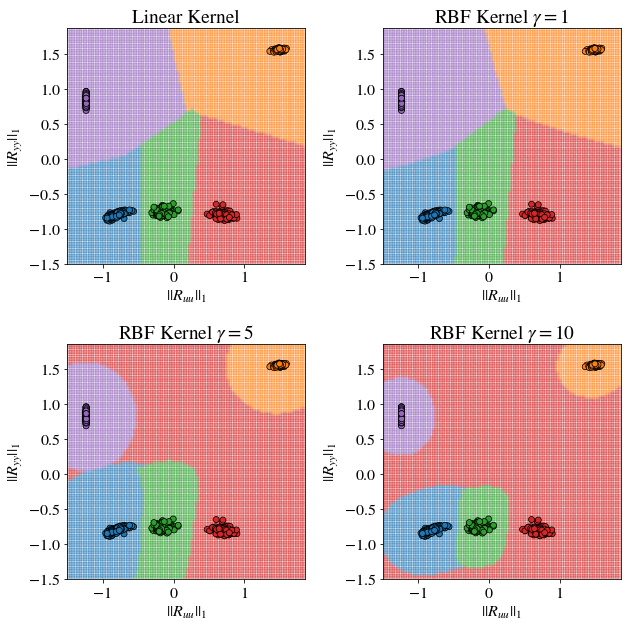

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))
label_names = []
class_names = ["Normal Operation", "Fault 1", "Fault 2", "Fault 3", "Fault 4"]
for yi in ys:
    label_names.append(class_names[yi.astype(int)])

clf = SVC(kernel='linear')
clf.fit(Xs, ys)
xx, yy = make_grid(Xs[:, 0], Xs[:, 1], n_points=100)
plot_contours(axes[0, 0], clf, xx, yy, cmap=palette_cmap, edgecolors='face', alpha=.15, shading='auto')
scatterplot(Xs, label_names=label_names, column_names=[r"$||R_{uu}||_{1}$", r"$||R_{yy}||_{1}$"],
            ax=axes[0, 0])
axes[0, 0].legend().remove()
axes[0, 0].set_title('Linear Kernel')

clf = SVC(kernel='rbf', gamma=1)
clf.fit(Xs, ys)
plot_contours(axes[0, 1], clf, xx, yy, cmap=palette_cmap, edgecolors='face', alpha=.15, shading='auto')
scatterplot(Xs, label_names=label_names, column_names=[r"$||R_{uu}||_{1}$", r"$||R_{yy}||_{1}$"],
            ax=axes[0, 1])
axes[0, 1].legend().remove()
axes[0, 1].set_title('RBF Kernel $\gamma=1$')

clf = SVC(kernel='rbf', gamma=5)
clf.fit(Xs, ys)
plot_contours(axes[1, 0], clf, xx, yy, cmap=palette_cmap, edgecolors='face', alpha=.15, shading='auto')
scatterplot(Xs, label_names=label_names, column_names=[r"$||R_{uu}||_{1}$", r"$||R_{yy}||_{1}$"],
            ax=axes[1, 0])
axes[1, 0].legend().remove()
axes[1, 0].set_title('RBF Kernel $\gamma=5$')

clf = SVC(kernel='rbf', gamma=10)
clf.fit(Xs, ys)
plot_contours(axes[1, 1], clf, xx, yy, cmap=palette_cmap, edgecolors='face', alpha=.15, shading='auto')
scatterplot(Xs, label_names=label_names, column_names=[r"$||R_{uu}||_{1}$", r"$||R_{yy}||_{1}$"],
            ax=axes[1, 1])
axes[1, 1].legend().remove()
axes[1, 1].set_title('RBF Kernel $\gamma=10$')

plt.tight_layout()

plt.savefig('./Figures/Ch3/SVM.pdf', transparent=True)

In [10]:
np.unique(ys, return_counts=True)

(array([0., 1., 2., 3., 4.]), array([200, 200, 200, 200, 200]))

In [ ]:
out = ax.contourf(xx, yy, Z, colors=[palette[0], palette[2], palette[1],
                                                  palette[3], palette[4]])